# Lorenz system

Here we consider the Lorenz system. It is a prototypical example of a chaotic attractor in 3D. Below we test the capabilities of the Koopman Kernel Sequencer to captuer the complex, chaotic dynamics.

In [1]:
import torch
import time
from kkseq.koopkernel_sequencer import (
    RBFKernel,
    NystroemKoopKernelSequencer,
    KoopKernelLoss,
)
import matplotlib.pyplot as plt
import numpy as np
from kkseq.data_utils import standardized_context_dataset_from_time_series_list, standardized_batched_context_from_time_series_list, LinearScaler
from kkseq.koopkernel_sequencer_utils import RMSE
from kooplearn.datasets import Lorenz63
from matplotlib.ticker import MultipleLocator
from kkseq.koopkernel_sequencer_utils import (
    eval_one_epoch,
    train_one_epoch,
)

Generate Lorenz63 data.

In [2]:
configs = {
    'train_samples': 10000,
    'test_samples': 100,
}


raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs["train_samples"] + 1000 + configs["test_samples"])
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

dataset = {
    "train": data[:configs["train_samples"] + 1],
    "test": data[-configs["test_samples"] - 1:],
}

time_series_list_train = [dataset["train"]]
time_series_list_test = [dataset["test"]]

Plot

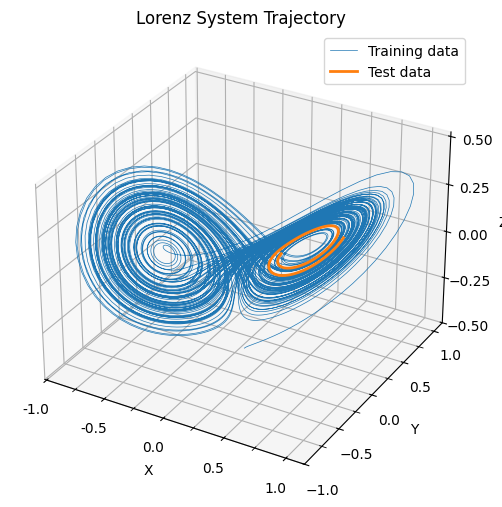

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset['train'][:,0], dataset['train'][:,1], dataset['train'][:,2], lw=.5, label='Training data')
ax.plot(dataset['test'][:,0], dataset['test'][:,1], dataset['test'][:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

plt.legend()
plt.show()

Set parameters.

In [4]:
flag_params = {}
flag_params["batch_size"] = 16
flag_params["koopman_kernel_length_scale"] = 10
flag_params["input_length"] = 12
flag_params["train_output_length"] = 1
flag_params["koopman_kernel_num_centers"] = 500
flag_params["context_mode"] = "full_context"
flag_params["mask_koopman_operator"] = False
flag_params["mask_version"] = 0
flag_params["use_nystroem_context_window"] = False

flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]

flag_params["learning_rate"] = 0.001
flag_params["decay_rate"] = 0.9

Define the model.

In [ ]:
scaler = LinearScaler()
eval_metric = RMSE
model_name = "test_model"

rbf = RBFKernel(length_scale=flag_params["koopman_kernel_length_scale"])
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    output_dim=1,
    num_nys_centers=flag_params["koopman_kernel_num_centers"],
    rng_seed=42,
    context_mode=flag_params["context_mode"],
    mask_koopman_operator=flag_params["mask_koopman_operator"],
    mask_version=flag_params["mask_version"],
    use_nystroem_context_window=flag_params["use_nystroem_context_window"],
)

Training and test sets and initialize Nystroem kernels.

In [7]:
tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        flag_params["batch_size"],
        scaler,
        context_length=flag_params["context_length"],
        time_lag=1,
        fit=True,
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
    )
)
tensor_context_inps_test, tensor_context_tgts_test = (
    standardized_batched_context_from_time_series_list(
        time_series_list_test,
        flag_params["batch_size"],
        scaler,
        context_length=flag_params["context_length"],
        time_lag=1,
        fit=False,
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
    )
)

print(tensor_context_inps_train.shape)

koopkernelmodel._initialize_nystrom_data(
    tensor_context_inps_train=tensor_context_inps_train,
    tensor_context_tgts_train=tensor_context_tgts_train,
)

torch.Size([16, 624, 12, 3])


Define optimizer, loss function and scheduler.

In [9]:
optimizer = torch.optim.Adam(koopkernelmodel.parameters(), lr=flag_params["learning_rate"])
loss_koopkernel = KoopKernelLoss(koopkernelmodel.nystrom_data_Y, koopkernelmodel._kernel)

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# tb_writer = SummaryWriter("runs/fashion_trainer_{}".format(timestamp))

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=flag_params["decay_rate"]
)  # stepwise learning rate decay

Training.

In [10]:
num_epochs = 5

all_train_rmses, all_eval_rmses = [], []
best_eval_rmse = 1e6

training_time_start = time.time()
for epoch_index, epoch in enumerate(range(num_epochs)):
    start_time = time.time()

    train_rmse = train_one_epoch(
        koopkernelmodel,
        optimizer,
        loss_koopkernel,
        tensor_context_inps_train,
        tensor_context_tgts_train,
    )
    eval_rmse, _, _ = eval_one_epoch(
        koopkernelmodel,
        loss_koopkernel,
        tensor_context_inps_test,
        tensor_context_tgts_test,
    )

    print("eval comparison", eval_rmse, best_eval_rmse)
    if eval_rmse < best_eval_rmse:
        best_eval_rmse = eval_rmse
        best_model = koopkernelmodel

    all_train_rmses.append(train_rmse)
    all_eval_rmses.append(eval_rmse)

    if np.isnan(train_rmse) or np.isnan(eval_rmse):
        raise ValueError("The model generate NaN values")

    # Save test scores.
    _, test_preds, test_tgts = eval_one_epoch(
        best_model,
        loss_koopkernel,
        tensor_context_inps_test,
        tensor_context_tgts_test,
    )

    scheduler.step()

training_runtime = time.time() - training_time_start

eval comparison 0.2402198104785365 1000000.0
eval comparison 0.21183141511862225 0.2402198104785365
eval comparison 0.8284917055496397 0.21183141511862225
eval comparison 1.1719747577168738 0.21183141511862225
eval comparison 2.9286628742096497 0.21183141511862225
